In [8]:
from esm_likelihood import get_esm_likelihood_scores
from Bio import SeqIO
import pandas as pd

testset_file = '../datasets/InterProUniprotPF03272prepared_test.fasta'
testset = list(SeqIO.parse(testset_file, 'fasta'))

# filter sequences with more than 1024 amino acids because ESM can't handle longer sequences
testset = [seq for seq in testset if len(seq) <= 1024]

# Calculate cutoff (10th percentile of ESM likelihood scores for the test set)
#testset_df = get_esm_likelihood_scores(testset)
testset_df = pd.read_csv("intermediate/basemodel-RITA_l-generated.fasta_testset_scores.csv")
cutoff = testset_df['score'].quantile(q=0.1)
cutoff

-0.4302726149559021

In [9]:
import glob

results = {}

for file in glob.glob("intermediate/*fasta_scores.csv"):
    df = pd.read_csv(file)
    filtered = df[df['score'] > cutoff]
    ids = list(filtered['id'])
    results[file] = ids

In [10]:
for k,v in results.items():
    print(k,len(v))

intermediate/finetuned-RITA_xl-generated.fasta_scores.csv 81
intermediate/finetuned-RITA_m-generated.fasta_scores.csv 33
intermediate/prompt-tuning-clustered-100-RITA_l-fromvocab-True-seed-0-generated.fasta_scores.csv 8
intermediate/prompt-tuning-clustered-100-RITA_m-fromvocab-True-seed-0-generated.fasta_scores.csv 5
intermediate/prompt-tuning-clustered-100-RITA_xl-fromvocab-True-seed-1-generated.fasta_scores.csv 18
intermediate/prompt-tuning-clustered-100-RITA_s-fromvocab-True-seed-0-generated.fasta_scores.csv 4
intermediate/prompt-tuning-clustered-100-RITA_l-fromvocab-True-seed-2-generated.fasta_scores.csv 10
intermediate/prompt-tuning-clustered-100-RITA_s-fromvocab-True-seed-1-generated.fasta_scores.csv 5
intermediate/prompt-tuning-clustered-100-RITA_s-fromvocab-True-seed-2-generated.fasta_scores.csv 6
intermediate/basemodel-RITA_l-generated.fasta_scores.csv 15
intermediate/finetuned-RITA_l-generated.fasta_scores.csv 60
intermediate/basemodel-RITA_xl-generated.fasta_scores.csv 10
in

In [47]:
import re

pattern = re.compile(".*(RITA_\w{1,2})-.*")
getModel = lambda filename: pattern.match(filename).groups()[0]

data = [
    (getModel(k), 'pt', len(v)) if 'prompt-tuning' in k 
    else ((getModel(k),'base',len(v))) if 'basemodel' in k
    else ((getModel(k),'fine',len(v)))
    for k,v in results.items()
]

order = ['RITA_s', 'RITA_m', 'RITA_l', 'RITA_xl']
data = sorted(data, key=lambda item: order.index(item[0]))
data

[('RITA_s', 'pt', 4),
 ('RITA_s', 'pt', 5),
 ('RITA_s', 'pt', 6),
 ('RITA_s', 'fine', 20),
 ('RITA_s', 'base', 5),
 ('RITA_m', 'fine', 33),
 ('RITA_m', 'pt', 5),
 ('RITA_m', 'pt', 7),
 ('RITA_m', 'pt', 6),
 ('RITA_m', 'base', 11),
 ('RITA_l', 'pt', 8),
 ('RITA_l', 'pt', 10),
 ('RITA_l', 'base', 15),
 ('RITA_l', 'fine', 60),
 ('RITA_l', 'pt', 8),
 ('RITA_xl', 'fine', 81),
 ('RITA_xl', 'pt', 18),
 ('RITA_xl', 'base', 10),
 ('RITA_xl', 'pt', 18),
 ('RITA_xl', 'pt', 19)]

Text(0.5, 1.0, 'Number of predicted active proteins per set')

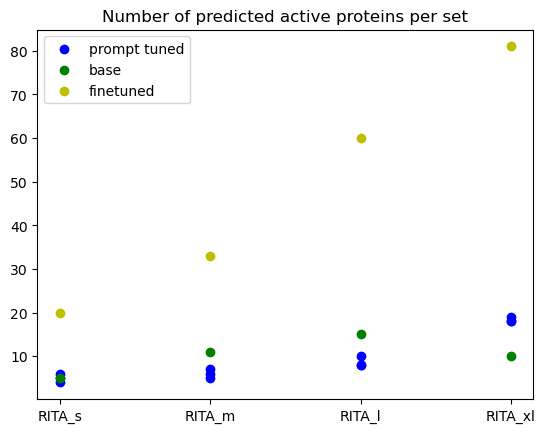

In [48]:
import matplotlib.pyplot as plt

keys, _, values = list(zip(*[t for t in data if t[1] == 'pt']))
plt.scatter(keys, values, c = 'b', label='prompt tuned')

keys, _, values = list(zip(*[t for t in data if t[1] == 'base']))
plt.scatter(keys, values, c = 'g', label='base')

keys, _, values = list(zip(*[t for t in data if t[1] == 'fine']))
plt.scatter(keys, values, c = 'y', label='finetuned')

plt.legend()
plt.title("Number of predicted active proteins per set")